In [2]:
from segment_anything import SamPredictor, sam_model_registry
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
import pickle
import os
import os.path as osp   
import tqdm
from scipy.ndimage import label


In [3]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=100):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    
def getImage(image,resize=(256,256)):
    cmap = matplotlib.colormaps["viridis"]
    norm = plt.Normalize(image.min(), image.max())
    rgba_image = cmap(norm(image))
    rgb_image = np.array(rgba_image[:, :, :3])
    rgb_array_scaled = (rgb_image * 255).astype(np.uint8)
    if resize==-1:
        return rgb_array_scaled
    image_pil = Image.fromarray(rgb_array_scaled)
    new_size = resize
    resized_image_pil = image_pil.resize(new_size, Image.LANCZOS)
    return np.array(resized_image_pil)
def show(image):
    plt.figure()
    plt.axis("off")
    plt.imshow(image)
    plt.show()

def to_origin(mask,size=(401,31)):
    mask_img=Image.fromarray(mask)
    mask_img=mask_img.resize(size,Image.LANCZOS)
    mask_img=np.array(mask_img)
    return mask_img

def display_result(image, mask):
    plt.figure()
    plt.imshow(image)
    # show_box(input_box, plt.gca())
    show_mask(mask, plt.gca())
    # show_points(input_point, input_label, plt.gca())
    # plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    # plt.savefig(f"./outputs/res{i}.jpg")
    plt.show()
def find_connected_masks(mask_matrix, target_point):
    # 标记连通区域
    labeled_matrix, num_labels = label(mask_matrix)

    # 找到与给定点相连的mask
    connected_mask = (labeled_matrix == labeled_matrix[target_point])
    # print(type(connected_mask))
    # print(connected_mask)

    return connected_mask

In [4]:
def S_inte(f, mask:np.ndarray, x_range=[0,2*np.pi],y_range=[-0.1,0.1]):
    y_len, x_len = mask.shape
    x_lis=np.linspace(x_range[0],x_range[1],x_len)
    y_lis=np.linspace(y_range[0],y_range[1],y_len)
    dj=f(x_lis,y_lis[:,None])*mask
    f=np.trapz(dj,x_lis)
    fg = np.trapz(f,y_lis)
    return fg

def FL(f_trap,delta,mask_origin, mgL,x_range=[0,2*np.pi]):
    def numerator(x,y):
        return mgL*np.sin(x-delta)*f_trap
    def denominator(x,y):
        return f_trap
    return S_inte(numerator,mask_origin, x_range=x_range)/S_inte(denominator,mask_origin,x_range=x_range)

In [5]:
sam = sam_model_registry["vit_h"](checkpoint="/home/wzy/segment-anything/checkpoints/sam_vit_h_4b8939.pth")
sam.to(device="cuda")
predictor = SamPredictor(sam)

mask_generator = SamAutomaticMaskGenerator(sam)

In [6]:
def find_min(arr,num_candidate=10):
    flattened_indices = np.argsort(arr.flatten())

    # 取前10个索引
    top_10_indices = flattened_indices[:num_candidate]

    # 将一维索引转换为二维索引
    row_indices, col_indices = np.unravel_index(top_10_indices, arr.shape)

    # 输出前10小的数和它们的位置
    # print("Top 10 smallest values:", arr[row_indices, col_indices])
    # print("Corresponding indices:", list(zip(row_indices, col_indices)))
    return arr[row_indices, col_indices], list(zip(row_indices, col_indices))
def distance(point1,point2):
    delta=np.array(point1)-np.array(point2)
    return delta[0]**2+delta[1]**2
def get_fix_point(f_trap,num_candidate=10):
    center=np.array(f_trap.shape)/2
    _, positions=find_min(f_trap,num_candidate)
    dists=np.array(list(map(lambda x:distance(center,x), positions)))
    min_index = np.argmin(dists)
    return list(positions[min_index])
def get_fix_points(f_trap,k=4,num_candidate=10):
    center=np.array(f_trap.shape)/2
    _, positions=find_min(f_trap,num_candidate)
    dists=np.array(list(map(lambda x:distance(center,x), positions)))
    dist_sort=np.argsort(dists)
    top_k=dist_sort[:k]
    print(top_k)
    return [list(positions[i]) for i in top_k]

def multi_point(input_point, radius=5, num_points=5):
    theta = np.linspace(0, 2*np.pi, num_points, endpoint=False)
    x = input_point[0] + radius * np.cos(theta)
    y = input_point[1] + radius * np.sin(theta)
    points = list(np.column_stack((x, y)))
    # points.append(input_point)
    return points


In [7]:
def _get_mask(f_trap,image, predictor,thre=0.8,div=8,input_point=[[145,128]], show=False, save=False, save_dir=None):
    # image=getImage(f_trap,(256,256))

    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    predictor.set_image(image)
    input_point = np.array(input_point)
    input_label = np.array([1]*len(input_point)) # 前景与背景
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=False,
    )
    # print(masks.shape) # (number_of_masks) x H x W
    mask=masks[0]
    score=scores[0]
    is_construct=True
    center_point=tuple(np.mean(input_point,axis=0).astype(int))
    mask=find_connected_masks(mask,center_point[::-1]) # 注意 网络输入point和数组point的xy索引是不一样的

    # print(np.sum(mask[:,-3:-1]) + np.sum(mask[:,0:2])+np.sum(mask[-3:-1,:])+np.sum(mask[0:2,:]))
    # print((mask.shape[0]+mask.shape[1])/8)
    if np.sum(mask[:,-3:-1]) + np.sum(mask[:,0:2])+np.sum(mask[-3:-1,:])+np.sum(mask[0:2,:])\
        >(mask.shape[0]+mask.shape[1])/div or score<thre:    
        is_construct=False
        # print("false")
    if show:
        plt.figure()
        plt.imshow(f_trap)
        # show_box(input_box, plt.gca())
        if is_construct:
            show_mask(mask, plt.gca())
        show_points(input_point, input_label, plt.gca())
        plt.title(f"Score: {score:.3f} {is_construct}", fontsize=10)
        plt.axis('off')
        # plt.savefig(f"./outputs/res{i}.jpg")
        plt.show()
    if save:
        plt.figure()
        plt.imshow(f_trap)
        # show_box(input_box, plt.gca())
        if is_construct:
            show_mask(mask, plt.gca())
        show_points(input_point, input_label, plt.gca())
        plt.title(f"Score: {score:.3f} {is_construct}", fontsize=10)
        plt.axis('off')
        plt.savefig(save_dir,bbox_inches='tight')
        plt.close()
        # plt.show()
    return mask, is_construct

def get_mask(f_trap,delta_f, predictor,multi_points=True,fix_cneter_x=True,radias=25,num_points=4,num_candidate=10,thre=0.6,div=40,input_point=None, show=False, save=False, save_dir=None):
    f_trap_2cir=getImage(np.concatenate((f_trap,f_trap),axis=0),(256,256*2))
    delta_f_trap_2cir=np.concatenate((delta_f,delta_f),axis=0)
    delta_f_trap_2cir_resize=to_origin(delta_f_trap_2cir,(256,256*2))
    image=getImage(delta_f_trap_2cir_resize,(256,256*2))
    # plt.imshow(image)


    if input_point is None:
        center_point=get_fix_point(delta_f_trap_2cir_resize,num_candidate=num_candidate)
        center_point.reverse()
        if fix_cneter_x:
            center_point[0]=delta_f_trap_2cir_resize.shape[1]//2
        if multi_points:
            input_point=multi_point(center_point,radius=radias,num_points=num_points)
            temp=[]
            for point in input_point:
                if point[1]<0 or point[1]>delta_f_trap_2cir_resize.shape[0]-1 or \
                point[0]<0 or point[0]>delta_f_trap_2cir_resize.shape[1]-1 or \
                    delta_f_trap_2cir_resize[int(point[1]),int(point[0])]>-0.0099: #0.1*delta_f_trap_2cir_resize[int(center_point[1]),int(center_point[0])]:
                    continue
                temp.append(point)
            input_point=temp
        else:
            input_point=[center_point]
        if not input_point:
            input_point=[center_point]

    
    # print(input_point)
    # plt.imshow(image)
    mask, is_construct=_get_mask(f_trap_2cir,image,predictor,thre=thre,div=div,input_point=input_point,show=show,save=save,save_dir=save_dir)
    return to_origin(mask,delta_f_trap_2cir.shape[::-1]), is_construct # 图片xy的顺序和数组xy的顺序是反的

def get_FL(f_trap,delta, mask_origin, mgL,x_range=[0,2*np.pi]):
    f_trap=np.transpose(f_trap)
    mask_origin=np.transpose(mask_origin)
    fl=FL(f_trap,delta,mask_origin, mgL,x_range=x_range)
    # print(fl)
    return fl
def get_alpha(f_trap, delta,mask_origin, mgL,x_range=[0,2*np.pi]):
    f_trap=np.transpose(f_trap)
    mask_origin=np.transpose(mask_origin)
    assert f_trap.shape==mask_origin.shape, f"{f_trap.shape}!={mask_origin.shape}"
    fl=FL(f_trap,delta,mask_origin, mgL,x_range=x_range)
    # print(fl)
    return fl/mgL


In [8]:
# 第一组数据
dist=np.load("/home/wzy/segment-anything/data/data1/newd.npy")
dist=dist.transpose(1,0,2,3)
feq_lis=np.load("/home/wzy/segment-anything/data/data1/feq.npy")
feq_lis=np.transpose(feq_lis)
print(dist.shape)
wb_lis=np.load("/home/wzy/segment-anything/data/data1/wb2.npy")
print(wb_lis.shape)
k_lis=np.load("/home/wzy/segment-anything/data/data1/kmode.npy")
print(k_lis.shape)
wb_cplx_lis=np.load("/home/wzy/segment-anything/data/data1/wb2_cplx.npy")
print(wb_cplx_lis.shape)
chor_lis=np.load("/home/wzy/segment-anything/data/data1/chor.npy")
print(chor_lis.shape)
alpha_lis=np.load("/home/wzy/segment-anything/data/data1/alpha.npy")
print(alpha_lis.shape)
zpos_lis=np.load("/home/wzy/segment-anything/data/data1/zpos.npy")
print(zpos_lis.shape)

(1001, 10, 31, 401)
(998, 1000)
(1001,)
(1000, 1001)
(1000, 1002, 2)
(1000, 1000)
(1001,)


In [9]:

# # 第二组数据
# zqs = [31,1201,201,8]
# cnum=np.prod(zqs)
# bs = cnum*8
# offset = 0
# dist = np.reshape(np.fromfile("/home/wzy/segment-anything/data/data2/dist.bin",offset=offset,count=cnum),zqs,'F')
# dist=dist.transpose(2,3,0,1)
# print(dist.shape)
# feq_lis=dist[:,0,:,:]

# print(feq_lis.shape)


In [10]:
# time=8
# space=900
# f_trap=dist[time,space,:,:]
# delta_f=f_trap-feq_lis[space]
# # mask,is_construct=get_mask(delta_f,predictor,radias=25,multi_points=False,fix_cneter_x=False,show=True)
# mask,is_construct=get_mask(f_trap,delta_f,predictor,num_points=4,div=40,radias=30,multi_points=False,fix_cneter_x=False,show=True)
# print(mask.shape)
# print(is_construct)

In [11]:
# root="/home/wzy/segment-anything/data/source_data4/scan_gradB"
root="/home/wzy/segment-anything/data/source_data3/cmp2/3"
lis=os.listdir(root)

for dir in ["3"]:
    zqs = [31,401,1001,10]
    cnum=np.prod(zqs)
    bs = cnum*8
    offset = 0
    dist = np.reshape(np.fromfile(f"/home/wzy/segment-anything/data/source_data3/cmp2/{dir}/dist.bin",offset=offset,count=cnum),zqs,'F')
    dist=dist.transpose(2,3,0,1)
    print(dist.shape)
    feq_lis=dist[:,0,:,:]

    mask_res_dir=f"/home/wzy/segment-anything/outputs/3/{dir}/mask_res"
    pict_res_dir=f"/home/wzy/segment-anything/outputs/3/{dir}/pict"
    os.makedirs(mask_res_dir, exist_ok=True)
    os.makedirs(pict_res_dir, exist_ok=True)
    for time in [6]:
        print(f"timestamp:{time}")
        for space in tqdm.tqdm(range(500,501)):
            f_trap=dist[space,time,:,:]
            delta_f=f_trap-feq_lis[space,:,:]
            mask,is_construct=get_mask(f_trap,delta_f,predictor,radias=25,div=20,multi_points=True,fix_cneter_x=False,save=True,save_dir=osp.join(pict_res_dir,f"{time}_{space}_3.jpg"))
            # print(mask.shape)
            # print(is_construct)
            with open(osp.join(mask_res_dir,f"{time}_{space}_{is_construct}.pkl"),"wb") as fp:
                pickle.dump((mask,is_construct),fp)

(1001, 10, 31, 401)
timestamp:6


100%|██████████| 1/1 [00:07<00:00,  7.11s/it]


In [12]:
dist.shape

(1001, 10, 31, 401)

timestamp:0


  0%|          | 0/1 [00:00<?, ?it/s]

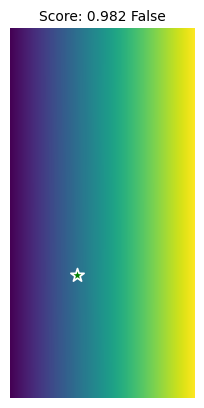

100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


timestamp:1


  0%|          | 0/1 [00:00<?, ?it/s]

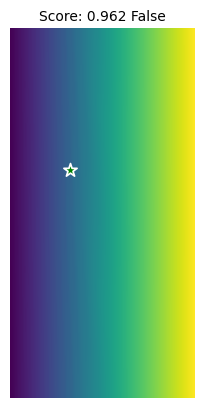

100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


timestamp:2


  0%|          | 0/1 [00:00<?, ?it/s]

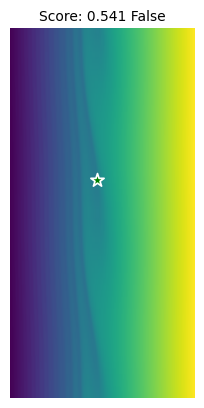

100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


timestamp:3


  0%|          | 0/1 [00:00<?, ?it/s]

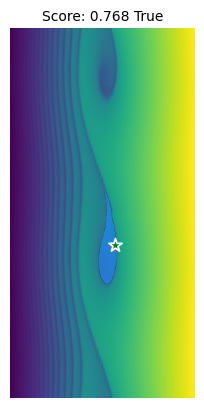

100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


timestamp:4


  0%|          | 0/1 [00:00<?, ?it/s]

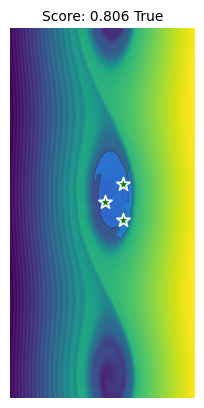

100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


timestamp:5


  0%|          | 0/1 [00:00<?, ?it/s]

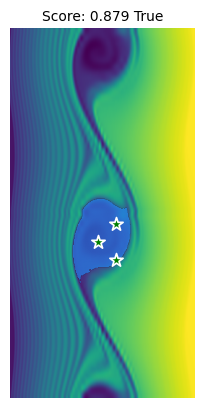

100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


timestamp:6


  0%|          | 0/1 [00:00<?, ?it/s]

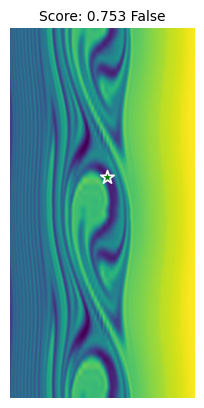

100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


timestamp:7


  0%|          | 0/1 [00:00<?, ?it/s]

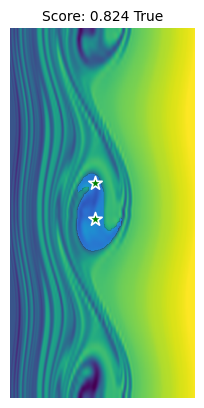

100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


timestamp:8


  0%|          | 0/1 [00:00<?, ?it/s]

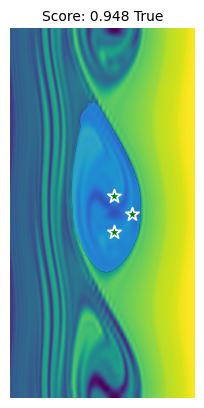

100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


timestamp:9


  0%|          | 0/1 [00:00<?, ?it/s]

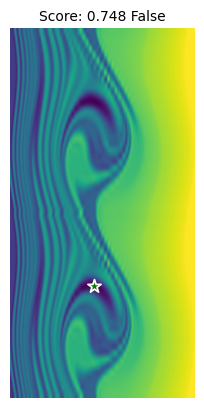

100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


In [13]:

mask_res_dir="/home/wzy/segment-anything/outputs/mask_res"
pict_res_dir="/home/wzy/segment-anything/outputs/picts_2"
os.makedirs(mask_res_dir, exist_ok=True)
os.makedirs(pict_res_dir, exist_ok=True)
for time in range(10):
    print(f"timestamp:{time}")
    for space in tqdm.tqdm(range(800,801)):
        f_trap=dist[space,time,:,:]
        delta_f=f_trap-feq_lis[space,:]
        mask,is_construct=get_mask(f_trap,delta_f,predictor,radias=25,div=20,multi_points=True,fix_cneter_x=False,save=True,show=True,save_dir=osp.join(pict_res_dir,f"{time}_{space}_2.jpg"))
        # print(mask.shape)
        # break
        # print(is_construct)
        with open(osp.join(mask_res_dir,f"{time}_{space}_{is_construct}.pkl"),"wb") as fp:
            pickle.dump((mask,is_construct),fp)

In [14]:
# import matplotlib.pyplot as plt

# plt.plot([1, 2, 3, 4])
# plt.savefig('/home/wzy/segment-anything/outputs/3/pict/plot.png')


In [15]:
fl_lis=[]
res_dir="/home/wzy/segment-anything/outputs/mask_res"
for time in range(dist.shape[0]):
    print(f"timestamp:{time}")
    temp=[]
    for space in tqdm.tqdm(range(dist.shape[1]-1)):

        m=1
        real_time=time*100
        omega2=wb_lis[real_time][space]
        k2=k_lis[space]**2

        mgL=m*omega2/k2

        # delta=np.angle(wb_cplx_lis[real_time][space])
        delta=np.angle(chor_lis[real_time+99][space][0]+chor_lis[real_time+99][space][1]*1j)
        # delta=chor_lis[real_time][space][1]*2

        f_trap=dist[time,space,:,:]
        f_trap_2cir=np.concatenate((f_trap,f_trap),axis=0)
        file_path=osp.join(res_dir,f"{time}_{space}_True.pkl")
        if osp.exists(file_path):
            with open(file_path,"rb") as fp:
                mask,is_construct=pickle.load(fp)
            fl=get_alpha(f_trap_2cir, delta,mask, mgL=mgL,x_range=[0,4*np.pi])
            temp.append(-1*fl)
        else:
            temp.append(None)
    fl_lis.append(temp)


timestamp:0


100%|██████████| 9/9 [00:00<00:00, 9840.65it/s]


timestamp:1


100%|██████████| 9/9 [00:00<00:00, 10439.36it/s]


timestamp:2


100%|██████████| 9/9 [00:00<00:00, 10459.61it/s]


timestamp:3


100%|██████████| 9/9 [00:00<00:00, 9694.08it/s]


timestamp:4


100%|██████████| 9/9 [00:00<00:00, 10133.89it/s]


timestamp:5


100%|██████████| 9/9 [00:00<00:00, 10567.96it/s]


timestamp:6


100%|██████████| 9/9 [00:00<00:00, 10532.57it/s]


timestamp:7


100%|██████████| 9/9 [00:00<00:00, 9957.46it/s]


timestamp:8


100%|██████████| 9/9 [00:00<00:00, 10615.51it/s]


timestamp:9


100%|██████████| 9/9 [00:00<00:00, 20718.30it/s]


timestamp:10


  0%|          | 0/9 [00:00<?, ?it/s]


IndexError: index 1000 is out of bounds for axis 0 with size 998

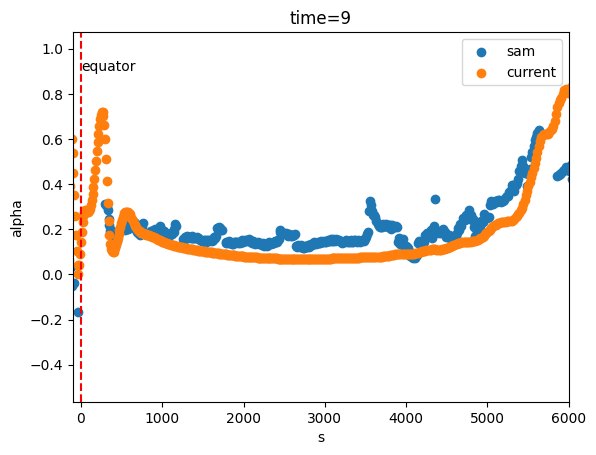

In [ ]:

def scatter(x_lis, y_lis):
    x=[]
    y=[]
    for i in range(len(x_lis)):
        if y_lis[i] is not None:
            x.append(x_lis[i])
            y.append(y_lis[i])
    # print(y)
    plt.scatter(x,y)

space_lis=zpos_lis[:1000]
for time in [9]:
    plt.figure()
    scatter(space_lis,fl_lis[time])
    scatter(space_lis,alpha_lis[100*time+99])
    plt.title(f"time={time}")
    plt.xlim((-100,6000))
    plt.xlabel("s")
    plt.ylabel("alpha")
    plt.axvline(x=0, color='r', linestyle='--')
    plt.text(0, 0.9, 'equator', ha='left')
    plt.legend(["sam","current"])
    plt.show()

In [ ]:
# time=9
# real_time=time*100+99
# alpha=alpha_lis[real_time,:]
# plt.plot(alpha,"ro")
# scatter(space_lis,[-i if i is not None else None for i in fl_lis[time]])
# plt.xlim((400,1050))